EntityId
TeamId
Name
ShortName
TeamAbbreviation
Minutes
OffPoss
DefPoss
TsPct
on
EntityId
TeamId
Name
ShortName
TeamAbbreviation
Minutes
OffPoss
DefPoss
TsPct
AtRimFG3AFrequency
on
Entities with both on/off data: ['1631128', '1631212', '1641816', '203932', '1629008', '1641725', '1630192', '1631124', '201566', '1629618', '1627750']


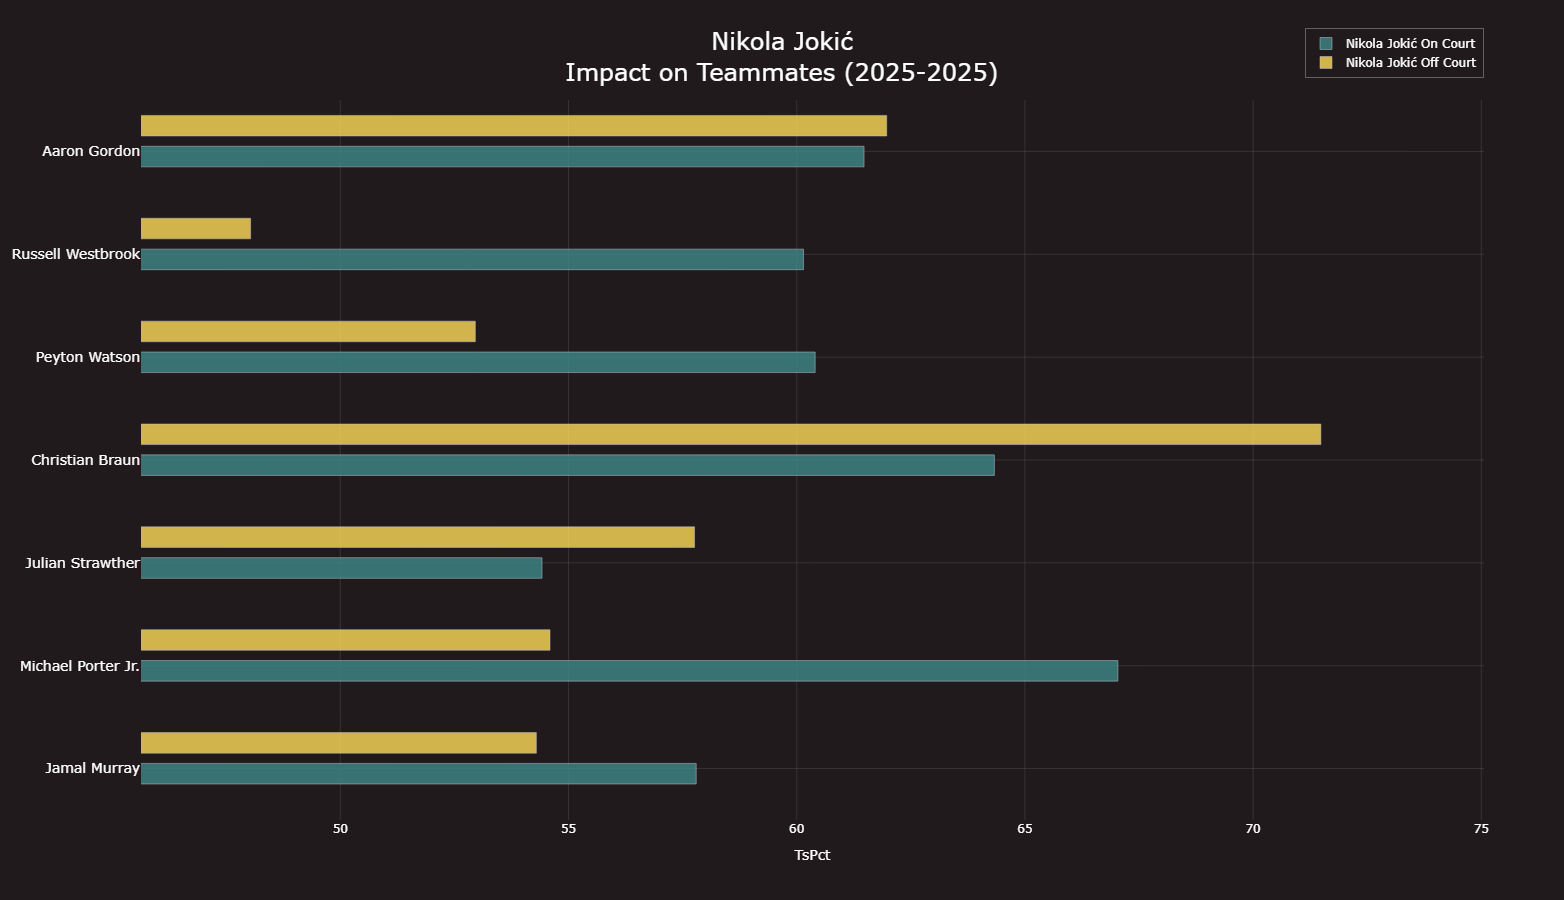

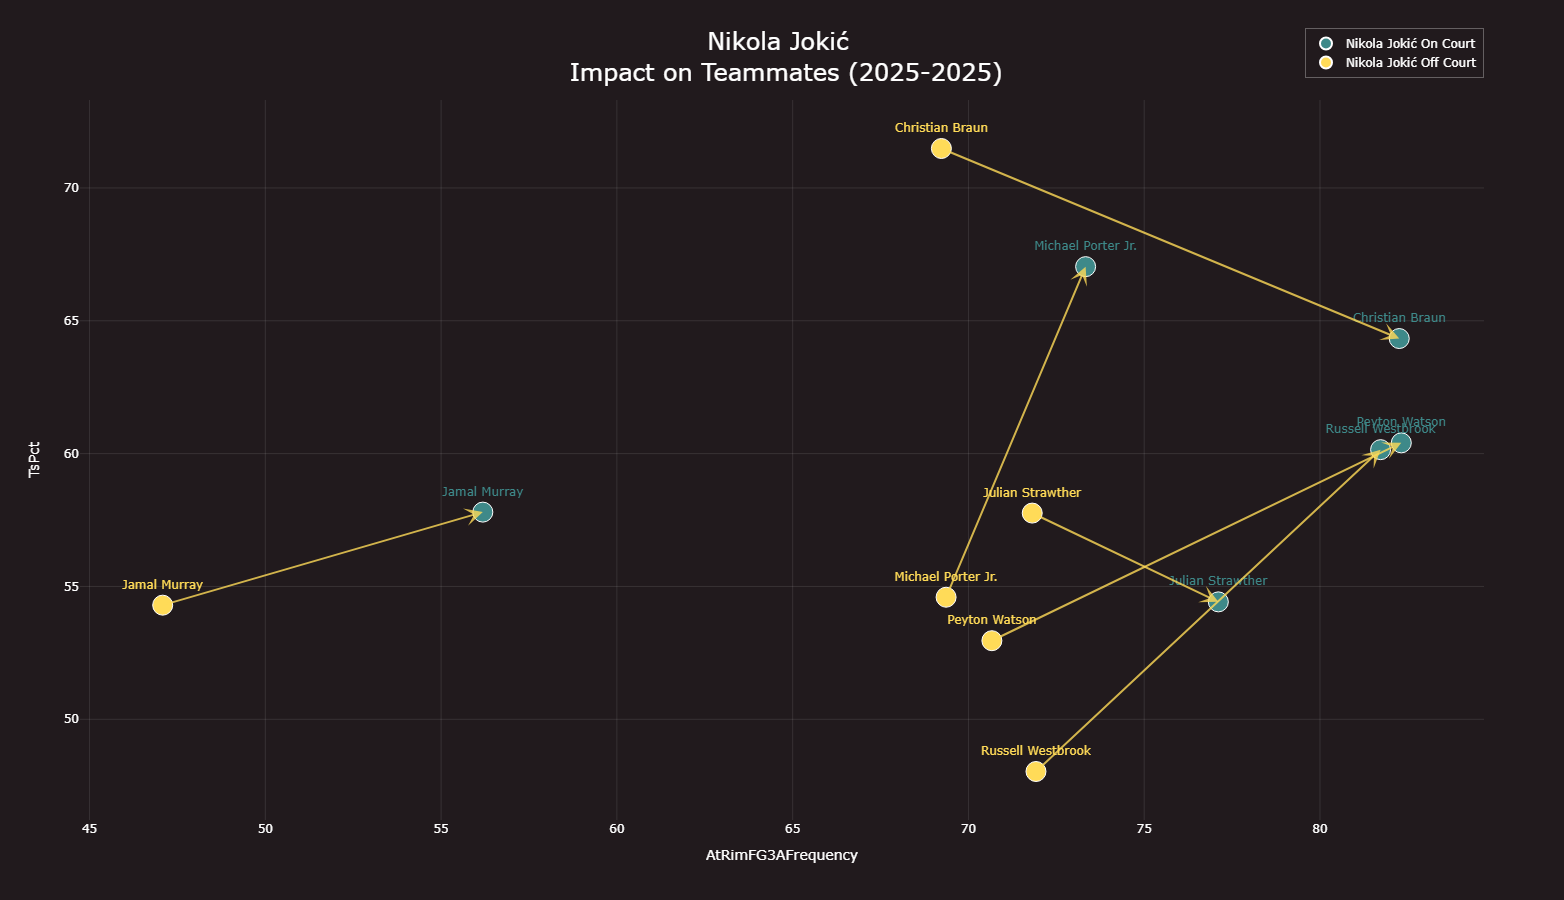

In [90]:
import plotly
import plotly.graph_objects as go
import numpy as np

import pandas as pd

import requests

from plotly.subplots import make_subplots

import plotly.graph_objects as go
import pandas as pd
import numpy as np

import plotly.graph_objects as go
import pandas as pd
import numpy as np

import plotly.graph_objects as go
import pandas as pd
import numpy as np

import plotly.graph_objects as go
import pandas as pd
import numpy as np
def shift_graphic_horizontal(start_year, end_year, team, player_id, metric_column, ps=False, n=5):
    player_id = str(player_id)
    trail = 'ps' if ps else ''
    frames = []
    columns = ['EntityId', 'TeamId', 'TeamAbbreviation', 'Name', 'ShortName', 
               'OffPoss', 'DefPoss', 'Minutes', 'on', metric_column]
    
    # Load data
    for year in range(start_year, end_year + 1):
        url_base = f'https://raw.githubusercontent.com/gabriel1200/playershift/refs/heads/main/data/{year}{trail}/{player_id}.csv'
        df = pd.read_csv(url_base,usecols=columns)
        for col in df.columns:
            print(col)
        df['Year'] = year
        frames.append(df)
    
    data = pd.concat(frames)

     
    # Filter by team
    data = data[data.TeamAbbreviation == team]
    data.dropna(subset=[metric_column], inplace=True)
    data['EntityId'] = data['EntityId'].astype(str)

    # Get player's short name
    name = data[data.EntityId == player_id]['ShortName'].iloc[0]

    # Find entities with both on/off data
    off_entities = set(data[data['on'] == False]['EntityId'])
    on_entities = set(data[data['on'] == True]['EntityId'])
    entities = list(off_entities.intersection(on_entities))

    # Filter to include only entities with both on/off data
    data = data[data.EntityId.isin(entities)]

    # Keep only the top n entities by Minutes
    total_minutes = data.groupby('EntityId')['Minutes'].sum()
    top_entities = total_minutes.nlargest(n).index.tolist()
    data = data[data.EntityId.isin(top_entities)]

    # Calculate per-possession stats if needed
    if any(keyword in metric_column.lower() for keyword in ['freq', 'accur', 'pct', '%']):
        data[metric_column] = data[metric_column] * 100
    elif 'rating' in metric_column.lower():
        pass
    else:
        data[metric_column] = 100 * data[metric_column] / data['OffPoss']
    xmin=data[metric_column].min() *.95
    xmax=data[metric_column].max() *1.05
    # Create figure
    fig = go.Figure()
    
    # Colors
    on_color = '#3e8989'  # Teal
    off_color = '#ffdb58'  # Yellow

    # Get unique players and sort by minutes
    players = data.groupby('EntityId').agg({
        'ShortName': 'first',
        'Minutes': 'sum',
        'Name': 'first'
    }).sort_values('Minutes', ascending=True)  # Ascending for bottom-to-top display

    # Add bars for each player
    for status, color in zip([True, False], [on_color, off_color]):
        status_label = f"{name} On Court" if status else f"{name} Off Court"
        
        # Filter data for current status
        status_data = data[data['on'] == status]
        
        fig.add_trace(go.Bar(
            x=status_data[metric_column],
            y=status_data['ShortName'],
            name=status_label,
            orientation='h',
            marker_color=color,
            opacity=0.8,
            width=0.2,  # Adjust bar width
            offset=-0.15 if status else 0.15,  # Offset bars for on/off comparison
            customdata=np.stack((
                status_data['Year'],
                status_data['TeamAbbreviation'],
                status_data['Minutes'],
                status_data['EntityId'],
                status_data['Name'],
                status_data[metric_column]
            ), axis=-1),
            hovertemplate=(
                f"<b>{status_label}</b><br>" +
                "Player: %{customdata[4]}<br>" +
                "Minutes: %{customdata[2]:.1f}<br>" +
                "Year: %{customdata[0]}<br>" +
                "Team: %{customdata[1]}<br>" +
                "<extra></extra>"
            ),
        ))

    # Update layout with dark theme
    fig.update_layout(
        title=dict(
            text=f"{name}<br>Impact on Teammates ({start_year}-{end_year})",
            x=0.5,
            font=dict(color='white', size=24)
        ),
        paper_bgcolor='#211a1d',
        plot_bgcolor='#211a1d',
        width=1200,
        height=max(600, 100 * len(players) + 200),  # Dynamic height based on number of players
        xaxis=dict(
            title=metric_column,
            gridcolor='rgba(255, 255, 255, 0.1)',
            zerolinecolor='rgba(255, 255, 255, 0.1)',
            tickfont=dict(color='white'),
            titlefont=dict(color='white'),
            range=[xmin,xmax]
        ),
        yaxis=dict(
            title=None,
            gridcolor='rgba(255, 255, 255, 0.1)',
            zerolinecolor='rgba(255, 255, 255, 0.1)',
            tickfont=dict(color='white', size=14),
            titlefont=dict(color='white')
        ),
        barmode='overlay',
        bargap=0.3,
        showlegend=True,
        legend=dict(
            font=dict(color='white'),
            bgcolor='rgba(0,0,0,0)',
            x=1,
            y=1.1,
            xanchor='right',
            yanchor='top',
            orientation='v',
            bordercolor='rgba(255, 255, 255, 0.3)',
            borderwidth=1
        )
    )
    
    return fig
def shift_graphic(start_year, end_year, team, player_id, x_column, y_column, ps=False, n=5):
    player_id = str(player_id)
    trail = 'ps' if ps else ''
    frames = []
    columns = ['EntityId', 'TeamId', 'TeamAbbreviation', 'Name', 'ShortName', 
               'OffPoss', 'DefPoss', 'Minutes', 'on', x_column, y_column]
    
    # Load data
    for year in range(start_year, end_year + 1):
        url_base = f'https://raw.githubusercontent.com/gabriel1200/playershift/refs/heads/main/data/{year}{trail}/{player_id}.csv'
        df = pd.read_csv(url_base,usecols=columns)
        for col in df.columns:
            print(col)
        df['Year'] = year
        frames.append(df)
    
    
    data = pd.concat(frames)
    
    # Filter by team
    data = data[data.TeamAbbreviation == team]
    data.dropna(subset=[x_column, y_column], inplace=True)
    data['EntityId'] = data['EntityId'].astype(str)

    # Get player's short name
    name = data[data.EntityId == player_id]['ShortName'].iloc[0]

    # Find entities with both on/off data
    off_entities = set(data[data['on'] == False]['EntityId'])
    on_entities = set(data[data['on'] == True]['EntityId'])
    entities = list(off_entities.intersection(on_entities))
    print("Entities with both on/off data:", entities)

    # Filter to include only entities with both on/off data
    data = data[data.EntityId.isin(entities)]

    # Keep only the top n entities by Minutes
    total_minutes = data.groupby('EntityId')['Minutes'].sum()
    top_entities = total_minutes.nlargest(n).index.tolist()
    
    data = data[data.EntityId.isin(top_entities)]


    # Calculate per-possession stats
    if any(keyword in x_column.lower() for keyword in ['freq', 'accur', 'pct', '%']):
        data[x_column] = data[x_column] * 100
    elif 'rating' in x_column:
        pass
    else:
        data[x_column] = 100 * data[x_column] / data['OffPoss']
        
    if any(keyword in y_column.lower() for keyword in ['freq', 'accur', 'pct', '%']):
        data[y_column] = data[y_column] * 100
    elif 'rating' in y_column:
        pass
    else:
        data[y_column] = 100 * data[y_column] / data['OffPoss']
        

    # Create figure
    fig = go.Figure()
    
    # Add scatter plots for on and off court
    on_color='#3e8989'
    off_color='#ffdb58'
    for status, color in zip([True, False], [on_color,off_color ]):  # Cyan and Pink
        mask = data['on'] == status
        status_label = name+ ' On Court' if status else name+ ' Off Court'
        
        fig.add_trace(go.Scatter(
            x=data[mask][x_column],
            y=data[mask][y_column],
            mode='markers+text',
            text=data[mask]['ShortName'],
            name=status_label,
            textposition="top center",
            textfont_color=color,

            marker=dict(
                size=20,
                color=color,
                symbol='circle',
                line=dict(color='white', width=1)
            ),
            customdata=np.stack((
                data[mask]['Year'],
                data[mask]['TeamAbbreviation'],
                data[mask]['Minutes'],
                data[mask]['EntityId'],
                data[mask]['Name']
            ), axis=-1),
            hovertemplate=(
                f"<b>{status_label}</b><br>" +
                "Year: %{customdata[0]}<br>" +
                "Team: %{customdata[1]}<br>" +
                "Player: %{customdata[4]}<br>" +
                "Minutes: %{customdata[2]:.1f}<br>" +
                "Entity ID: %{customdata[3]}<br>" +
                "<extra></extra>"
            ),
        ))
    
    for entity_id in data['EntityId'].unique():
        entity_data = data[data['EntityId'] == entity_id]
        
        off_data = entity_data[~entity_data['on']].iloc[0]
        on_data = entity_data[entity_data['on']].iloc[0]
        
        # Calculate differences for hover info
        x_diff = on_data[x_column] - off_data[x_column]
        y_diff = on_data[y_column] - off_data[y_column]
        
        # Add an annotation for the arrow
        fig.add_annotation(
            x=on_data[x_column],  # Arrowhead position (end)
            y=on_data[y_column],
            ax=off_data[x_column],  # Arrow tail position (start)
            ay=off_data[y_column],
            xref="x",
            yref="y",
            axref="x",
            ayref="y",
            showarrow=True,
            arrowhead=3,  # Style of arrowhead
            arrowsize=1.5,  # Size of the arrowhead
            arrowwidth=2,  # Thickness of the arrow line
            arrowcolor=off_color,  # Color of the arrow
            opacity=0.8  # Slight transparency for better visibility
        )
        
    # Update layout with dark theme
    fig.update_layout(
        title=dict(
            text=f"{name} <br> Impact on Teammates ({start_year}-{end_year})",
            x=.5,
            font=dict(color='white', size=24)
        ),
        paper_bgcolor='#211a1d',
        plot_bgcolor='#211a1d',
        width=1200,
        height=900,
        xaxis=dict(
            title=x_column,
            gridcolor='rgba(255, 255, 255, 0.1)',
            zerolinecolor='rgba(255, 255, 255, 0.1)',
            tickfont=dict(color='white'),
            titlefont=dict(color='white')
        ),
        yaxis=dict(
            title=y_column,
            gridcolor='rgba(255, 255, 255, 0.1)',
            zerolinecolor='rgba(255, 255, 255, 0.1)',
            tickfont=dict(color='white'),
            titlefont=dict(color='white')
        ),
        hovermode='closest',
        showlegend=True,
        legend=dict(
            font=dict(color='white'),
            bgcolor='rgba(0,0,0,0)',
            x=1,  # Position the legend on the right side
            y=1.1,  # Position the legend at the top
            xanchor='right',  # Anchor point for x
            yanchor='top',  # Anchor point for y
            orientation='v',  # Vertical orientation
            bordercolor='rgba(255, 255, 255, 0.3)',
            borderwidth=1,  # Border width
            itemsizing='constant'  # Keep legend item sizes constant
        )
    )
    
    return fig


x_column,y_column='AtRimFG3AFrequency','TsPct'
team='DEN'
player_id=203999
fig = shift_graphic_horizontal(2025,2025,team,player_id,y_column,n=7)

fig2 = shift_graphic(2025,2025,team,player_id,x_column,y_column,n=6)

fig.show()
fig2.show()